In [77]:
import pandas as pd
import numpy as np
from script import *
import itertools
import lightgbm as lgbm
import matplotlib.pyplot as plt

import time

In [2]:
pd.set_option('display.max_rows',200)
idx = pd.IndexSlice
agg_operations =['mean','median','max','min','size']

In [3]:
start = 20130101
start_date = '-'.join([str(start)[:4],str(start)[4:6],str(start)[6:8]])
print(start_date)
# df_r = pd.read_parquet(r"database\return_8%_20%_60_20")
# df_rs = pd.read_parquet(r"database\return_5%_10%_20_8_inf%").loc[idx[:,start_date:],:].sort_index()
# df_rs_sp = pd.read_parquet(r"database\return_5%_10%_20_8_15% v0").loc[idx[:,start_date:],:].sort_index()
df_rs = pd.read_parquet(r"database\return_5%_10%_20_8_inf%").loc[idx[:,
                                                             start_date:],:].sort_index()
df_rs_sp = pd.read_parquet(r"database\return_5%_10%_20_8_15%").loc[idx[:,start_date:],:].sort_index()

df_rs1 = pd.read_parquet(r"database\return_5%_10%_20_8_inf% v1").loc[idx[:,
                                                             start_date:],:].sort_index()
df_rs_sp1 = pd.read_parquet(r"database\return_5%_10%_20_8_15% v1").loc[idx[:,
                                                                    start_date:],:].sort_index()


2013-01-01


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pyarrow\pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pyarrow\pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pyarrow\pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
print(df_rs.shape==df_rs1.shape==df_rs_sp.shape==df_rs_sp1.shape)

inter_index = df_rs_sp.index.intersection(df_rs.index).intersection # 避免范围不同导致的差别
# if len(inter_index)==len(df_rs_sp)==len(df_rs):
#     res = pd.DataFrame([df_rs_sp2.loc[:,'r'].agg(agg_operations[:4]),
#                     df_rs_sp.loc[:,'r'].agg(agg_operations[:4]),
#                     df_rs.loc[:,'r'].agg(agg_operations[:4])],
#                    index=['stop_profit2','stop_profit',"not_stop_profit"]).T
# else:
#     res = pd.DataFrame([df_rs_sp.loc[inter_index,'r'].agg(agg_operations[:4]),
#                     df_rs.loc[inter_index,'r'].agg(agg_operations[:4])],
#                    index=['stop_profit',"not_stop_profit"]).T

res = pd.DataFrame([df_rs['r'].agg(agg_operations[:4]),
                    df_rs_sp['r'].agg(agg_operations[:4]),
                    df_rs1['r'].agg(agg_operations[:4]),
                    df_rs_sp1['r'].agg(agg_operations[:4])],
                   index=['base','sp',"zth","sp_zth"]).T

res['sp/|base|-1'] = (res['sp']-res['base'])/res['base'].abs()*100
res['zth/|base|-1'] = (res['zth']-res['base'])/res['base'].abs()*100
res['sp_zth/|base|-1'] = (res['sp_zth']-res['base'])/res['base'].abs()*100


# print("不止盈的收益统计",df_rs.r.agg(agg_operations[:4]))
# print("止盈的收益统计",df_rs_sp.loc[inter_index,'r'].agg(agg_operations[:4]))
print(res)

# 结论：
# 偏短模式下15%收盘次日开盘止盈，mean提升了10.68%，提升明显，
#   表明止盈减少的利润回撤远大于放弃的进一步涨幅，大部分个股短期涨幅在15%附近，继续大涨的个股比例较小。
# median提升了0.39%，推测是中位数以上的赚钱样本提升明显，但中位数以下基本达不到止盈条件，相当于不变，所以中位数最终提升轻微。

True
             base         sp        zth     sp_zth  sp/|base|-1  zth/|base|-1  \
mean     0.002524   0.002258   0.002670   0.002674   -10.559584      5.766437   
median  -0.008578  -0.008574  -0.008584  -0.008584     0.035727     -0.071531   
max     10.329513  10.329513  10.329513  10.329513     0.000000      0.000000   
min     -0.872727  -0.872727  -0.872727  -0.872727     0.000000      0.000000   

        sp_zth/|base|-1  
mean           5.927999  
median        -0.071531  
max            0.000000  
min            0.000000  


In [5]:
cursor = dbop.connect_db("sqlite3").cursor()

df_d = dbop.create_df(cursor, STOCK_DAY[TABLE], start=start)
df_d = dp.proc_stock_d(dp.prepare_stock_d(df_d))
df_d.drop(columns=['open0','high0','low0','vol0'],inplace=True)
df_d['pct'] = df_d.sort_index().groupby('code')['close'].pct_change()*100
print(df_d.columns)
print(df_d.shape)

select * from stock_day where date>=20130101


In [7]:
df_d_basic = dbop.create_df(cursor, STOCK_DAILY_BASIC[TABLE], start=start,
                            # where_clause="code in ('002349.SZ','600352.SH','600350.SH','600001.SH')",
                            # where_clause="code='600350.SH'",
                            )
df_d_basic = dp.prepare_stock_d_basic(df_d_basic)
#
df_d_basic["pb*pe_ttm"] = df_d_basic["pb"] * df_d_basic["pe_ttm"]
df_d_basic["pb*pe"] = df_d_basic["pb"] * df_d_basic["pe"]

select * from stock_daily_basic where date>=20130101


In [65]:
df = df_d.join(df_d_basic.drop(columns=['close']))

In [66]:
periods = [5,10,20,30,60,120,250]
for k in periods:
    df['{:d}ma'.format(k)]=df.reset_index('code').groupby('code')['close'].rolling(k).mean()
print(df.columns)
    
for col1,col2 in itertools.combinations(['close']+["{}ma".format(k) for k in periods],2):
    df['{}/{}'.format(col1,col2)] = df[col1]/df[col2]
print(df.columns)

ops = ['max','mean','median','std']
for k in [10,30,60,120]:
#     for col1,col2 in itertools.combinations(['close']+["{}ma".format(k) for k in periods],2):
#         col = '{}/{}'.format(col1,col2)
#         df[['{}_p{}{}'.format(col,k,op) for op in ops]] = df[col].reset_index('code').groupby('code')[col].rolling(k).agg(ops)
    for col2 in ["{}ma".format(k) for k in periods]:
        col = '{}/{}'.format('close',col2)
        df[['{}_p{}{}'.format(col,k,op) for op in ops]] = df[col].reset_index('code').groupby('code')[col].rolling(k).agg(ops)
print(df.columns)

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '30ma', '60ma', '120ma', '250ma'],
      dtype='object')
Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '30ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/30ma', 'close/60ma',
       'close/120ma', 'close/250ma', '5ma/10ma', '5ma/20ma', '5ma/30ma',
       '5ma/60ma', '5ma/120ma', '5ma/250ma', '10ma/20ma', '10ma/30ma',
       '10ma/60ma', '10ma/120ma

In [43]:
# print(pd.cut(df['close']/df['60ma'],bins=np.arange(0,2,0.1)).dropna().head())
vals, cnts = np.unique(pd.cut(df['close']/df['60ma'],bins=np.arange(0,2,0.1)).dropna(),return_counts=True)
distribution = pd.DataFrame([vals,cnts],index=['val','cnt']).T
distribution['pct'] = distribution['cnt']/len(df['60ma'].dropna())*100
print(distribution)

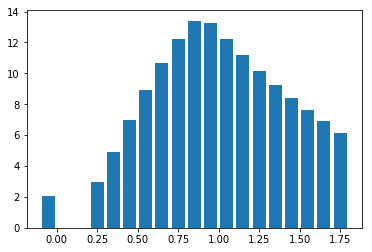

In [41]:
plt.bar(distribution['val'].astype('str').str[1:4].astype('float')-0.05,np.log(distribution['cnt'].astype('float')),width=0.08)
plt.show()

In [67]:
df_sample = df[df['close/60ma'] <0.9]
print(len(df_sample),len(df_sample)/len(df))

254109 0.11026035883464005


In [ ]:
dataset = df_sample.join(df_rs_sp1.r,how='left')
# print(dataset.loc[dataset.r<=-0.2,['open','high','low','close']].reset_index('code').resample('Q').size())
# # dataset = dataset[dataset.r>-0.2]
# dataset.loc[dataset.r<=-0.3,['open','high','low','close']].sort_values('date',ascending=False).head(50)
# del df_rs,df_rs1,df_rs_sp
# df_sample.columns
# del df_d, df_d_basic

In [81]:
def udf(y_true,y_pred):
    preds = 1. / (1. + np.exp(-y_pred))
    grad = preds * (1-preds)
    grad[y_true==1] *= -1 
    hess = np.ones(len(grad))
    return grad,hess

In [104]:
dataset = dataset[dataset['r'].notnull()]
dataset_train = dataset.loc[idx[:,:'2019-01-01'],:]
dataset_test = dataset.loc[idx[:,'2019-01-01':],:]
print(len(dataset),len(dataset_train),len(dataset_test))
# print((dataset_train['r']>0).astype('int').sum(),(dataset_train['r']>0).sum())

252395 203266 49129


In [175]:
kwargs = {'n_estimators':50, 'num_leaves':12, 'max_depth':8, 'min_child_samples':len(dataset)//25, 'random_state':1}
kwargs['learning_rate'] = 5/kwargs['n_estimators']

reg = lgbm.LGBMRegressor(**kwargs)
clf1 = lgbm.LGBMClassifier(objective=udf,**kwargs)
clf2 = lgbm.LGBMClassifier(objective=udf,**kwargs)
callbacks = [lgbm.reset_parameter(learning_rate=lambda x:5/(kwargs['n_estimators']+x*2))]

In [176]:
t0 = time.time()
reg.fit(dataset_train.drop(columns='r'),dataset_train['r'],
         callbacks=callbacks,
        )
print(time.time()-t0,reg.score(dataset_train.drop(columns='r'),dataset_train['r']))

w1 = np.sqrt(dataset_train['r'].abs())
clf1.fit(dataset_train.drop(columns='r'),(dataset_train['r']>0).astype('int'),
         callbacks=callbacks,sample_weight= w1+np.mean(w1)
        )
print(time.time()-t0,clf1.score(dataset_train.drop(columns='r'),(dataset_train['r']>0).astype('int')))

w2 = np.sqrt((dataset_train['r']-0.04).abs())
clf2.fit(dataset_train.drop(columns='r'),(dataset_train['r']>0).astype('int'),
         callbacks=callbacks,sample_weight= w2+np.mean(w2)
        )
print(time.time()-t0,clf2.score(dataset_train.drop(columns='r'),(dataset_train['r']>=0.04).astype('int')))


8.332220315933228 0.06257793315822979
20.355294704437256 0.5293802209912135
32.184552907943726 0.7342005057412455


In [177]:
y_pred_reg = reg.predict(dataset_test.drop(columns='r'))
# print(y_pred_reg)
# print(dataset_test.shape)
y_pred_clf1 = clf1.predict_proba(dataset_test.drop(columns='r'))
# print(y_pred_clf)
print(y_pred_clf1.shape,y_pred_clf1.max(axis=0),y_pred_clf1.min(axis=0))

y_pred_clf2 = clf2.predict_proba(dataset_test.drop(columns='r'))
# print(y_pred_clf)
print(y_pred_clf2.shape,y_pred_clf2.max(axis=0),y_pred_clf2.min(axis=0))

(49129, 2) [1.18177106 0.25740008] [ 0.74259992 -0.18177106]
(49129, 2) [1.26901669 0.16162903] [ 0.83837097 -0.26901669]


In [178]:
rs_reg = pd.DataFrame([dataset_test['r'].values,y_pred_reg],index=['true','pred']).T
rs_clf1 = pd.DataFrame([dataset_test['r'].values,y_pred_clf1[:,1]],index=['true','pred']).T
rs_clf2 = pd.DataFrame([dataset_test['r'].values,y_pred_clf2[:,1]],index=['true','pred']).T

mean     -0.033553
median    0.002593
max       0.260870
min      -0.671642
Name: true, dtype: float64
mean      0.012052
median    0.008070
max       0.188925
min      -0.554711
Name: true, dtype: float64
mean      0.016984
median    0.008488
max       0.181208
min      -0.098081
Name: true, dtype: float64
                          median      mean  size
bin                                             
(-0.0362, -0.0226]      0.029862  0.036056   492
(-0.0226, -0.0188]      0.045662  0.051686   491
(-0.0188, -0.0165]      0.038741  0.048403   491
(-0.0165, -0.0147]      0.032927  0.041119   492
(-0.0147, -0.0129]      0.021053  0.033073   491
(-0.0129, -0.0116]      0.006623  0.021109   491
(-0.0116, -0.0105]      0.007533  0.024818   491
(-0.0105, -0.00962]     0.002423  0.015075   492
(-0.00962, -0.00887]    0.000000  0.016092   491
(-0.00887, -0.00818]    0.002532  0.018296   491
(-0.00818, -0.00763]   -0.003714  0.011659   492
(-0.00763, -0.00711]   -0.004530  0.009728   491
(-0.0

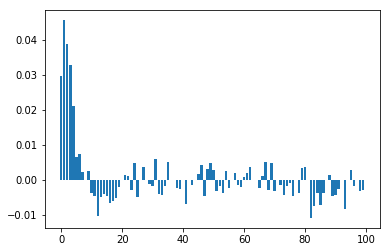

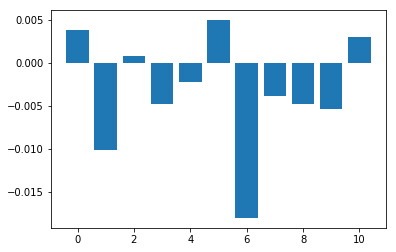

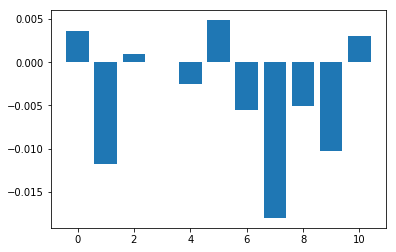

In [179]:
head=20
# print(rs_reg.sort_values('pred',ascending=False)[:head])
# print(rs_clf1.sort_values('pred',ascending=False)[:head])
# print(rs_clf2.sort_values('pred',ascending=False)[:head])

top_cnt = 100
print(rs_reg.sort_values('pred',ascending=False)[:top_cnt]['true'].agg(['mean','median','max','min']))
print(rs_clf1.sort_values('pred',ascending=False)[:top_cnt]['true'].agg(['mean','median','max','min']))
print(rs_clf2.sort_values('pred',ascending=False)[:top_cnt]['true'].agg(['mean','median','max','min']))

q=100
for e in [rs_reg,rs_clf1,rs_clf2]:
#     print(e)
    e['bin'] = pd.qcut(e['pred'],q=q,duplicates='drop')
    y = e.groupby('bin')['true'].agg(['median','mean','size']).sort_index()
    print(y)
    plt.figure()
    plt.bar(range(len(y)),y['median'])

plt.show()

In [153]:
dataset_train['r'].abs()

code       date      
000001.SZ  2013-04-15    0.036552
           2013-04-16    0.016043
           2013-04-17    0.097695
           2013-04-25    0.044760
           2013-04-26    0.066667
                           ...   
603997.SH  2017-05-26    0.056667
           2017-05-31    0.040506
           2017-11-23    0.017969
           2017-12-04    0.023831
           2017-12-05    0.016799
Name: r, Length: 203266, dtype: float64

In [186]:
import ml_model as ml
print(list(df.columns))
result = ml.assess_feature3(df[['close/{}ma'.format(k) for k in periods]],df_rs_sp1.r,q_bin=100)

['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg', 'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share', 'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm', 'pb*pe', '5ma', '10ma', '20ma', '30ma', '60ma', '120ma', '250ma', 'close/5ma', 'close/10ma', 'close/20ma', 'close/30ma', 'close/60ma', 'close/120ma', 'close/250ma', '5ma/10ma', '5ma/20ma', '5ma/30ma', '5ma/60ma', '5ma/120ma', '5ma/250ma', '10ma/20ma', '10ma/30ma', '10ma/60ma', '10ma/120ma', '10ma/250ma', '20ma/30ma', '20ma/60ma', '20ma/120ma', '20ma/250ma', '30ma/60ma', '30ma/120ma', '30ma/250ma', '60ma/120ma', '60ma/250ma', '120ma/250ma', 'close/5ma_p10max', 'close/5ma_p10mean', 'close/5ma_p10median', 'close/5ma_p10std', 'close/10ma_p10max', 'close/10ma_p10mean', 'close/10ma_p10median', 'close/10ma_p10std', 'close/20ma_p10max', 'close/20ma_p10mean', 'close/20ma_p10median', 'close/20ma_p10std', 'close/30ma_p10max', 'close/30ma_

close/20ma 
                     mean    median
bin                               
(0.407, 0.806]  0.012269  0.012929
(0.806, 0.847]  0.003514  0.002326
(0.847, 0.869]  0.003483 -0.000799
(0.869, 0.883]  0.003111 -0.003335
(0.883, 0.894]  0.002148 -0.005642
(0.894, 0.903]  0.002763 -0.005168
(0.903, 0.91]   0.003435 -0.005722
(0.91, 0.916]   0.002727 -0.007131
(0.916, 0.921]  0.002439 -0.007747
(0.921, 0.926]  0.002696 -0.007699
(0.926, 0.93]   0.002604 -0.008086
(0.93, 0.934]   0.002296 -0.008237
(0.934, 0.937]  0.002439 -0.008742
(0.937, 0.94]   0.002612 -0.008853
(0.94, 0.943]   0.002410 -0.008918
(0.943, 0.946]  0.002012 -0.009855
(0.946, 0.949]  0.001658 -0.009787
(0.949, 0.951]  0.002044 -0.010240
(0.951, 0.954]  0.001817 -0.010147
(0.954, 0.956]  0.002205 -0.010152
(0.956, 0.958]  0.002105 -0.010191
(0.958, 0.96]   0.002066 -0.009840
(0.96, 0.962]   0.001398 -0.010367
(0.962, 0.964]  0.001802 -0.010676
(0.964, 0.966]  0.001077 -0.010526
(0.966, 0.967]  0.001262 -0.011000
(0.967,

close/5ma 
                       mean    median
bin                                 
(0.7351, 0.9028]  0.009642  0.007644
(0.9028, 0.9234]  0.001465 -0.001905
(0.9234, 0.9356]  0.003629 -0.002494
(0.9356, 0.9439]  0.005064 -0.002078
(0.9439, 0.9498]  0.006859 -0.001946
(0.9498, 0.9544]  0.006903 -0.002237
(0.9544, 0.9582]  0.005471 -0.004410
(0.9582, 0.9613]  0.006008 -0.004031
(0.9613, 0.964]   0.006104 -0.005055
(0.964, 0.9663]   0.005424 -0.005084
(0.9663, 0.9684]  0.004418 -0.006430
(0.9684, 0.9702]  0.004105 -0.007712
(0.9702, 0.9719]  0.003506 -0.007675
(0.9719, 0.9735]  0.004461 -0.007671
(0.9735, 0.9749]  0.004242 -0.007249
(0.9749, 0.9762]  0.002700 -0.008563
(0.9762, 0.9774]  0.002713 -0.008578
(0.9774, 0.9786]  0.002819 -0.009512
(0.9786, 0.9797]  0.001771 -0.010365
(0.9797, 0.9807]  0.001538 -0.010695
(0.9807, 0.9817]  0.002993 -0.009069
(0.9817, 0.9826]  0.002101 -0.009444
(0.9826, 0.9835]  0.001252 -0.010740
(0.9835, 0.9843]  0.002101 -0.009804
(0.9843, 0.9851]  0.001707

In [189]:
result.sort_values(['median_std','mean_std','median_q96%','mean_q96%'],ascending=False)

,mean_std,median_std,mean_q96%,median_q96%,mean_q4%,median_q4%
close/30ma,0.002255,0.003686,0.004375,-0.004620,0.000332,-0.010761
close/60ma,0.002793,0.003642,0.005221,-0.003355,0.000467,-0.010681
close/120ma,0.003110,0.003092,0.006740,-0.003878,-0.000734,-0.011396
close/20ma,0.001658,0.002911,0.004341,-0.005095,0.000844,-0.010677
close/5ma,0.001808,0.002601,0.006012,-0.002231,0.001063,-0.010697
close/10ma,0.001397,0.002289,0.004680,-0.002832,0.000771,-0.010442
close/250ma,0.001755,0.001302,0.005906,-0.006982,0.001079,-0.009908


In [204]:
columns=['close/{}ma'.format(k) for k in periods]
t0 = time.time()
reg.fit(dataset_train[columns],dataset_train['r'],
         callbacks=callbacks,
        )
print(time.time()-t0,reg.score(dataset_train[columns],dataset_train['r']))

w1 = np.sqrt(dataset_train['r'].abs())
# w1 = dataset_train['r'].abs()
clf1.fit(dataset_train[columns],(dataset_train['r']>0).astype('int'),
         callbacks=callbacks,sample_weight= w1+np.mean(w1)
        )
print(time.time()-t0,clf1.score(dataset_train[columns],(dataset_train['r']>0).astype('int')))

w2 = np.sqrt((dataset_train['r']-0.005).abs())
# w2 = (dataset_train['r']-0.01).abs()
clf2.fit(dataset_train[columns],(dataset_train['r']>0).astype('int'),
         callbacks=callbacks,sample_weight= w2+np.mean(w2)
        )
print(time.time()-t0,clf2.score(dataset_train[columns],(dataset_train['r']>=0.04).astype('int')))


0.7365765571594238 0.029658441420069348
3.1592464447021484 0.5293802209912135
5.490082740783691 0.7342005057412455


In [205]:
y_pred_reg = reg.predict(dataset_test[columns])
# print(y_pred_reg)
# print(dataset_test.shape)
y_pred_clf1 = clf1.predict_proba(dataset_test[columns])
# print(y_pred_clf)
print(y_pred_clf1.shape,y_pred_clf1.max(axis=0),y_pred_clf1.min(axis=0))

y_pred_clf2 = clf2.predict_proba(dataset_test[columns])
# print(y_pred_clf)
print(y_pred_clf2.shape,y_pred_clf2.max(axis=0),y_pred_clf2.min(axis=0))

(49129, 2) [1.15537932 0.23824456] [ 0.76175544 -0.15537932]
(49129, 2) [1.17457802 0.22088478] [ 0.77911522 -0.17457802]


In [206]:
rs_reg = pd.DataFrame([dataset_test['r'].values,y_pred_reg],index=['true','pred']).T
rs_clf1 = pd.DataFrame([dataset_test['r'].values,y_pred_clf1[:,1]],index=['true','pred']).T
rs_clf2 = pd.DataFrame([dataset_test['r'].values,y_pred_clf2[:,1]],index=['true','pred']).T

mean      0.042249
median    0.023476
max       0.557377
min      -0.499145
Name: true, dtype: float64
mean      0.008486
median   -0.006229
max       0.286885
min      -0.107692
Name: true, dtype: float64
mean      0.005912
median   -0.013331
max       0.355330
min      -0.076336
Name: true, dtype: float64
                                    median      mean  size
bin                                                       
(-0.028300000000000002, -0.0245]  0.017887  0.029898   493
(-0.0245, -0.0217]                0.046901  0.054677   499
(-0.0217, -0.0199]                0.066282  0.071371   482
(-0.0199, -0.017]                 0.050116  0.058409   494
(-0.017, -0.0123]                 0.047723  0.059673   490
(-0.0123, -0.00991]               0.024355  0.034909   493
(-0.00991, -0.009]               -0.006178  0.008936   488
(-0.009, -0.00752]                0.001372  0.013299   492
(-0.00752, -0.00638]             -0.002805  0.009654   493
(-0.00638, -0.00534]              0.000000

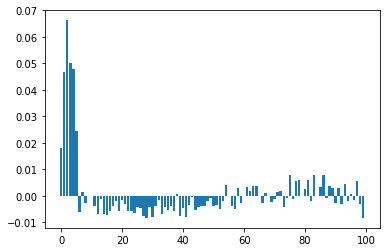

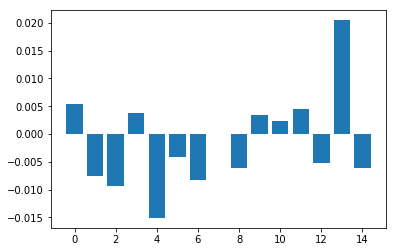

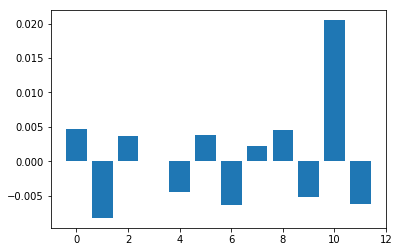

In [207]:
head=20
# print(rs_reg.sort_values('pred',ascending=False)[:head])
# print(rs_clf1.sort_values('pred',ascending=False)[:head])
# print(rs_clf2.sort_values('pred',ascending=False)[:head])

top_cnt = 100
print(rs_reg.sort_values('pred',ascending=False)[:top_cnt]['true'].agg(['mean','median','max','min']))
print(rs_clf1.sort_values('pred',ascending=False)[:top_cnt]['true'].agg(['mean','median','max','min']))
print(rs_clf2.sort_values('pred',ascending=False)[:top_cnt]['true'].agg(['mean','median','max','min']))

q=100
for e in [rs_reg,rs_clf1,rs_clf2]:
#     print(e)
    e['bin'] = pd.qcut(e['pred'],q=q,duplicates='drop')
    y = e.groupby('bin')['true'].agg(['median','mean','size']).sort_index()
    print(y)
    plt.figure()
    plt.bar(range(len(y)),y['median'])

plt.show()

In [195]:
len(df)/100

23046.27

In [227]:
index = df.index[(df['close/120ma']<=0.69)
                 & (df['close/30ma']<=0.778)
#                  & (df['close/60ma']<=0.74)
                 & (df['close/60ma']<=0.65)
                 & (df['close/60ma']>=0.55)
                 & (df['close0']>1)
                ]
print(len(index))

0


In [225]:
print(df_rs_sp1.loc[index,'r'].agg(agg_operations))
df_rs_sp1.loc[index,'r'].reset_index('code',drop=True).resample('Q').agg(agg_operations)

mean         0.063106
median       0.057460
max          1.204987
min         -0.554711
size      1261.000000
Name: r, dtype: float64


,mean,median,max,min,size
date,,,,,
2015-09-30,0.087767,0.086368,0.655405,-0.399556,758
2015-12-31,0.067704,0.067704,0.093423,0.041985,2
2016-03-31,0.065872,0.049557,1.204987,-0.112522,156
2016-06-30,NaN,NaN,NaN,NaN,0
2016-09-30,NaN,NaN,NaN,NaN,0
2016-12-31,NaN,NaN,NaN,NaN,0
2017-03-31,NaN,NaN,NaN,NaN,0
2017-06-30,-0.093796,-0.093796,-0.038410,-0.149181,2
2017-09-30,NaN,NaN,NaN,NaN,0


In [220]:
df.loc[index,:].sort_values('date',ascending=False)[:50]

open       high        low      close  \
code      date                                                     
000687.SZ 2020-04-01   12.41306   12.44625   11.55012   11.71607   
002447.SZ 2020-04-01   34.96570   35.51779   33.12540   33.49346   
002353.SZ 2020-04-01  178.80470  186.46194  178.80470  185.07712   
002583.SZ 2020-04-01   32.49516   34.01310   32.32650   32.88870   
002506.SZ 2020-04-01   15.39294   16.15749   15.39294   15.74973   
002411.SZ 2020-04-01   32.32816   33.41132   32.03654   32.36982   
          2020-03-31   34.45282   34.45282   32.16152   32.16152   
002353.SZ 2020-03-31  178.39740  184.83274  177.09404  180.10806   
002583.SZ 2020-03-31   34.18176   34.35042   32.77626   32.77626   
300618.SZ 2020-03-31  106.54761  106.84440  103.12311  105.06366   
002506.SZ 2020-03-31   16.41234   16.71816   15.34197   15.44391   
000687.SZ 2020-03-30   12.57901   12.71177   11.74926   12.21392   
300618.SZ 2020-03-30  106.09101  106.77591  101.95878  104.78970   
002353.SZ 2020-03-30  178.07156  179.61930  169.27388  175.62776   
002411.SZ 2020-03-30   34.57780   35.99424   33.95290   34.11954   
002506.SZ 2020-03-30   16.97301   17.48271   15.90264   16.71816   
002411.SZ 2020-03-27   33.74460   36.49416   33.74460   34.99440   
002353.SZ 2020-03-27  192.73436  193.63042  185.48442  185.64734   
002506.SZ 2020-03-27   17.83950   18.09435   16.97301   16.97301   
002411.SZ 2020-03-26   38.28554   39.49368   36.82744   36.82744   
002506.SZ 2020-03-26   18.14532   20.18412   18.14532   18.85890   
          2020-03-25   20.18412   20.18412   20.18412   20.18412   
002411.SZ 2020-03-24   40.95178   41.16008   38.36886   39.61866   
002086.SZ 2020-03-24    9.49210    9.57464    9.28575    9.53337   
          2020-03-23    9.57464    9.57464    9.45083    9.45083   
002681.SZ 2020-03-23   36.96804   37.07427   35.48082   35.58705   
300618.SZ 2020-03-23  111.86700  112.96284  104.17329  105.88554   
002086.SZ 2020-03-20   10.23496   10.27623    9.73972    9.94607   
          2020-03-19   10.52385   10.56512   10.19369   10.23496   
600816.SH 2020-02-13   94.44020   95.36912   91.34380   91.34380   
          2020-02-07   91.03416   93.20164   90.41488   91.96308   
000669.SZ 2020-02-07   10.00374   10.22280    9.82119   10.04025   
600280.SH 2020-02-07   22.37235   23.17546   22.14289   22.71654   
000687.SZ 2020-02-07   16.03077   16.32948   15.79844   16.13034   
          2020-02-06   16.19672   16.39586   15.43335   16.19672   
000669.SZ 2020-02-06    9.74817    9.85770    9.52911    9.85770   
600280.SH 2020-02-06   21.79870   22.48708   21.33978   22.48708   
600816.SH 2020-02-06   90.72452   93.51128   87.31848   93.20164   
002124.SZ 2020-02-05   94.53860  100.13260   93.75544   96.66432   
000620.SZ 2020-02-05    5.09232    5.27360    5.02640    5.17472   
000669.SZ 2020-02-05    9.23703    9.60213    9.23703    9.60213   
000615.SZ 2020-02-05   29.37039   30.18876   29.00667   29.91597   
000687.SZ 2020-02-05   15.36697   17.09285   15.36697   16.22991   
600280.SH 2020-02-05   21.22505   22.25762   21.22505   21.91343   
600816.SH 2020-02-05   88.24740   95.67876   88.24740   92.27272   
600280.SH 2020-02-04   21.22505   22.02816   21.22505   21.22505   
300156.SZ 2020-02-04   10.84656   11.49000   10.84656   11.30616   
000687.SZ 2020-02-04   16.36267   16.36267   16.36267   16.36267   
002426.SZ 2020-02-04    8.74322    9.11191    8.74322    8.79589   
002447.SZ 2020-02-04   41.03869   43.06302   41.03869   41.95884   

                               vol          amt  adj_factor         avg  \
code      date                                                            
000687.SZ 2020-04-01  6.138847e+04    72740.891       3.319   11.849276   
002447.SZ 2020-04-01  3.940128e+04   133263.021      18.403   33.822001   
002353.SZ 2020-04-01  3.850542e+04   706458.523       8.146  183.469886   
002583.SZ 2020-04-01  6.130780e+04   204595.962       5.622   33.371928   
002506.SZ 2020-04-01  6.837400e+05  1074